# The Cart Pole Problem
The goal of this project is to balance a pole on a cart which you can move back and forth.
There are two possible actions, add force to left and add force to right. Scoring takes place for how long you keep the pole in the air

I am going to attempt to implement (from scratch) a simple 1 fully connected hidden layer ANN with N nodes and 2 outputs

In [1]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1 
Define an "Agent" which has .run(), .update(), .reset() In this case the agent will be implemented in numpy for the practice

In [168]:
class activation:
    def __init__(self, type='linear'):
        self.type = type
        
    def _sigmoid(self, x):
        return 1/(1+np.exp(x))
    
    def activate(self, x):
        if self.type == 'linear':
            return x
        if self.type == 'relu':
            mask = x > 0
            return mask*x
        if self.type == 'sigmoid':
            return self._sigmoid(x)
        
    def derivative(self, x):
        if self.type == 'linear':
            return 1
        if self.type == 'relu':
            return 1*(x>0)
        if self.type == 'sigmoid':
            return self._sigmoid(x)*(1-self._sigmoid(x))

In [390]:
class agent():
    def __init__(self, e_size, h_size, a_size, lr=0.01, gamma=0.99, a1='linear', a2='linear', discount='exp'):
        # Record Agent Parameters
        self.e_size = e_size
        self.h_size = h_size
        self.a_size = a_size
        
        self.lr = lr
        self.gamma = gamma
        self.A1 = activation(a1)
        self.A2 = activation(a2)
        self.discount = discount
        
        # Initialize weights and biases
        self.hidden_weights = np.random.standard_normal((e_size, h_size))
        self.hidden_bias = np.zeros((1, h_size))
        
        self.action_weights = np.random.standard_normal((h_size, a_size))
        self.action_bias = np.zeros((1, a_size))
        
        # Initialize Replay history
        self.history = []
    
    def reset(self):
        self.history = []
    
    def discountedReward(self, rewards):
        if self.discount == 'exp':
            for i in xrange(rewards.shape[0]-2, -1, -1):
                rewards[i] = rewards[i] + self.gamma*rewards[i+1]
        elif (self.discount == 'lin'):
            for i in xrange(rewards.shape[0]):
                rewards[i] = min(np.sum(rewards[i:]), 30)
        
        return rewards
    
    def record(self, s, a, r):
        # Ensuring state s is a proper row vector
        if (len(s.shape)==1):
            s = s[None, :]
            
        self.history.append([s, a, r])
    
    def forward_pass(self, s):
        # Implement the forward pass returning the various intermediate results
        
        # Check the observation has the correct number of dimensions
        assert (len(s.shape) <= 2 and len(s.shape) != 0)
        # If it has one dimension turn into a row vector
        if (len(s.shape)==1):
            s = s[None,:]
            
        # If it has 2 dimensions ensure it is a vector not a matrix
        assert (s.shape[0] == 1 or s.shape[1] == 1)
        # Convert to row matrix if its a column
        if (s.shape[0] !=1):
            s = s.T
            
        # Input Checking complete. Run forward pass
        hidden_input = np.dot(s, self.hidden_weights) + self.hidden_bias
        hidden_output = self.A1.activate(hidden_input)
        
        action_input = np.dot(hidden_output, self.action_weights) + self.action_bias
        action_output = self.A2.activate(action_input)
        
        return [hidden_input, hidden_output, action_input, action_output]
    
    def update(self):
#         print ("UPDATING")
        # Function to use back propagation with the history to improve weights
        
        # Input checking
        assert len(self.history) > 0
        
        # Applying discounted reward to this particular replay
        history = np.array(self.history)
        history[:,2] = self.discountedReward(history[:,2])
        
        # Prepare for gradients
        HWChange = np.zeros(self.hidden_weights.shape)
        HBChange = np.zeros(self.hidden_bias.shape)
        
        AWChange = np.zeros(self.action_weights.shape)
        ABChange = np.zeros(self.action_bias.shape)
        for i in xrange(history.shape[0]):
            # For each step of history:
                # Apply forward pass
                # 
            state = history[i, 0]
            action = history[i, 1]
            reward = history[i, 2]
            
            (HI, H, A, yhat) = self.forward_pass(state)
            
            main_error_term = np.zeros((1, self.a_size))
            main_error_term[0, action] = -1*(reward-yhat[0,action])
            
            main_error_term = main_error_term*self.A1.derivative(A)
            
            hidden_error_term = np.dot(main_error_term, self.action_weights.T)
            hidden_error_term = hidden_error_term*self.A2.derivative(HI)
            
            AWChange += np.dot(H.T, main_error_term)
            ABChange += main_error_term*1
            
            HWChange += np.dot(state.T, hidden_error_term)
            HBChange += hidden_error_term*1
        
        run_length = 1#10*np.sqrt(history.shape[0])
        
        self.hidden_weights -= self.lr*HWChange/run_length
        self.hidden_bias -= self.lr*HBChange/run_length
        
        self.action_weights -= self.lr*AWChange/run_length
        self.action_bias -= self.lr*ABChange/run_length
        
        # Delete history
        self.history = []
                
    def predict(self, s):
        # Return the Q values prdicted for input state S
        return self.forward_pass(s)[-1]
    
    def choose_action(self, s):
        # Use the prediction to make a decision
        return np.argmax(self.predict(s))
            
        

### Test Agent
Implement tests for the back-propagation

In [391]:
e_size = 2
h_size = 3
a_size = 2

init_h_weights = np.array([[0.1, 0.5, 0.2], [0.3, -0.1, 0.6]])
init_h_bias = np.zeros((1,3))
init_a_weights = np.array([[-0.1, 0.1], [0.4, 0.3], [0.2, 0]])
init_a_bias = np.zeros((1,2))

exp_h_weights = np.array([[0.146, 0.638, 0.2],[0.392, 0.176, 0.6]])
exp_h_bias = np.array([0.0092, 0.0276, 0])
exp_a_weights = np.array([[-0.1, 0.422],[0.4, 0.438],[0.2, 0.644]])
exp_a_bias = np.array([0, 0.092])

state = np.array([5, 10])
action = 1
reward = 10

test_agent = agent(e_size, h_size, a_size, lr=0.01, gamma=0.99)

test_agent.hidden_weights = init_h_weights
test_agent.hidden_bias = init_h_bias
test_agent.action_weights = init_a_weights
test_agent.action_bias = init_a_bias

test_agent.record(state, action, reward)

test_agent.update()

assert(np.allclose(test_agent.hidden_weights, exp_h_weights))
assert(np.allclose(test_agent.hidden_bias, exp_h_bias))
assert(np.allclose(test_agent.action_weights, exp_a_weights))
assert(np.allclose(test_agent.action_bias, exp_a_bias))

print("All Tests Passed!")


All Tests Passed!


### Step 2
Now that we have the agent we can start using it to play the game. This section we run through a bunch of games (restart when hit done) and after each game we run the update

In [392]:
def softmax(x):
    """Compute the softmax of vector x."""
    exps = np.exp(x-x.mean())
    return exps / np.sum(exps)

In [393]:
# Training Parameter
MAX_GAMES = 100000 # This is like epochs
MAX_GAME_TIME = 999

LEARNING_RATE = 0.0001
DECAY = 1
# DECAY = 0.99996
GAMMA = 0.8576
HIDDEN_NODES = 10

REPORT_INTERVAL = 5000 # How often to report the progress.

env = gym.make('CartPole-v0')
e_size = 4
a_size = 2
player = agent(e_size, HIDDEN_NODES, a_size, lr=LEARNING_RATE, gamma=GAMMA, a1='relu')

avgScore = 0.
runCount = 0.
bestScore = 0

for i_episode in range(MAX_GAMES):
    state = env.reset()
    player.reset()
    running_reward = 0
    
    for t in range(MAX_GAME_TIME):
        
        Q_vals = player.predict(state)
        # Do a weighted sample to pick your action
        action_prob = softmax(Q_vals[0,:])
        action = np.random.choice(range(a_size), p=action_prob)
        
        new_state, reward, done, info = env.step(action)
        player.record(state, action, reward)
        running_reward += reward
        state = new_state
        if done:
            avgScore += running_reward
            runCount += 1
            if (running_reward > bestScore):
                bestScore = running_reward
            player.update()
            if (i_episode > MAX_GAMES/2.0):
                player.lr = 0.0001 #player.lr*DECAY
            if (i_episode % REPORT_INTERVAL == 0 or i_episode == MAX_GAMES-1):
                print("Round: {0:7d}   Avg Score: {1:7.2f}    Max Score: {2:5f}".format(i_episode, avgScore/runCount, bestScore))
                avgScore = 0.
                runCount = 0.
                bestScore = 0
            break

[2017-11-23 12:49:59,116] Making new env: CartPole-v0


Round:       0   Avg Score:   16.00    Max Score: 16.000000
Round:    5000   Avg Score:   11.42    Max Score: 31.000000
Round:   10000   Avg Score:   30.26    Max Score: 153.000000
Round:   15000   Avg Score:   32.92    Max Score: 173.000000
Round:   20000   Avg Score:   35.73    Max Score: 200.000000
Round:   25000   Avg Score:   35.86    Max Score: 180.000000
Round:   30000   Avg Score:   36.58    Max Score: 164.000000
Round:   35000   Avg Score:   37.27    Max Score: 200.000000
Round:   40000   Avg Score:   36.55    Max Score: 196.000000
Round:   45000   Avg Score:   36.10    Max Score: 200.000000
Round:   50000   Avg Score:   36.39    Max Score: 200.000000
Round:   55000   Avg Score:   35.38    Max Score: 182.000000
Round:   60000   Avg Score:   35.93    Max Score: 190.000000
Round:   65000   Avg Score:   35.67    Max Score: 179.000000
Round:   70000   Avg Score:   34.78    Max Score: 194.000000
Round:   75000   Avg Score:   34.59    Max Score: 186.000000
Round:   80000   Avg Score

In [406]:
from gym.wrappers import Monitor
env = gym.make('CartPole-v0')
env = Monitor(env, './cart-pole-monitor')
state = env.reset()
done = False
t = 0
while t<200:
#     env.render()
    action = player.choose_action(state)
    state, reward, done, info = env.step(action)
    t += 1
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.reset()
env.render(close=True)

[2017-11-23 13:25:36,821] Making new env: CartPole-v0
[2017-11-23 13:25:36,826] Starting new video recorder writing to /home/dennis/Documents/ML/ReinforcementLearning/cart-pole-monitor/openaigym.video.7.9899.video000000.mp4
[2017-11-23 13:25:43,744] Starting new video recorder writing to /home/dennis/Documents/ML/ReinforcementLearning/cart-pole-monitor/openaigym.video.7.9899.video000001.mp4


Episode finished after 201 timesteps


# Notes
Being my first reinforcement learning project I wanted to implement it from scratch using numpy (because numpy is a bit easier to debug then tensorflow)

On the whole this was very enlightening. I decided to go for a DQN which predicts the actual Q values rather than one which predicts actions directly simply because the Q prediction model made a lot more sense to me. When you get a reward you try to update the network to better reflect what the expected reward for that action is. Beautiful in its simplicity.

My biggest challenge was getting the model to converge. Even now it is somewhat hit-and miss. Mostly it seemed like early on it needed a larger learning rate but as it when on it needed to fine tune. That said sometimes it seems like it would get stuck in a rut right from the start and not be able to break out.

I am sure that there are work-arounds for this the two ideas I tried is learning rate decay both exponential decay and discrete value decay. Both had improvements though both would still exhibit finding a peak and then falling off

I suspected that the reason was that the early states tend to be similar and sometimes good courses of action were being unfairly punished early on because it was having trouble learning. As such I tried normalizing by the sqrt(length of the run) thinking this would allow more movement to remember good moves more easily and not as heavily punish bad moves. (Carrot vs Stick) 

It appears to be successful because the few tests I have done with it have converged much easier, but testing the bot doesn't seem te reflect the performance I was expecting. The average score is not great but the max is. I suspect that while possibly in the right direction, the is too much Carrot right now :P

In the end I have decided to move on and do some more reading. As a first attempt it did pretty good but on the whole I think I am running into some wall i need to better understand.

It occurs to me that if the same state is reached but at different times in the run then the target reward will be vastly different... Maybe using discounted reward is not the best policy in this case since the only thing that gives reward is staying in the air longer.

## Additional results
Continuing in the investigation I realized I could tune the carrot stick ratio by adding a multiplicative factor out front of the sqrt. Ultimately if this works I think the same effect could be produced by a linear function but thats an investigation for another time.

When Using the sqrt(run_length) as the normalizing factor the behaviour observed was that the bot would have a high max score for each reporting interval (often 200) but the average score remained around 30-40 This suggests to me that it was learning only one good path and was woefully unprepared for other starting states.

The hope is that by normalizing by 10*sqrt(run_length) we will more evenly balance the carrot-stick ratio (centered on 100 as the crossing point.

Its also worth noting that the avg score might be a poor metric. there is some randomness in the motions during training to avoid exploitation. to get a better metric we should really be testing the game properly.

To be honest though I don't have enough experience at this point to really understand the implications here but it seems like maybe there is something to the idea.

as for using the reward as the final reward... That idea didn't seem to pan out. When testing it it immediately dropped the quality of results. Visual testing seems like it learned one direction too well and ignored other situations. Maybe a constant reward if it wins for the next X moves and then a taper after that. A discrete convergent dynamical system could be good there...

Interestingly it seems like normalizing the reward structure has helped a lot. It kind of makes sense. actions which will will help keep the pole in the air for a period greater then the typical influence time (i estimate about 30 steps though it might be less) all give the same reward. My only concernis that the linear dropoff is not a sufficient penalty for making mistakes.

### Final thoughts
I think what I took from this more than anything else is that the way we discount rewards has the biggest impact on the performance of all the factors. Ultimately I think using smarter optimizers will help but we can't escape the fact that how we consider the impact of an action on future rewards is probably the most critical aspect of this problem. However I also think that this could be coded in the game side if care is taken. for instance if we assume exponential decay of rewards we can tailor the the rewards being given to be more constant if the game is to remain constant. It doesn't make a lot of sense to give a reward for an action much larger just because that particular run went longer. The effect of that action ultimately has a time period of influence. 

HOWEVER with proper gamma tuning I think we can still do quite a bit. For instance in this case reducing gamma drastically should mean that some effective window of future events is considered. Lets say we consider 0.01 to be negliable then 0.01=gamma^N. If we want the effective period to be 30 time steps then gamma = 0.85 would be appropriate.

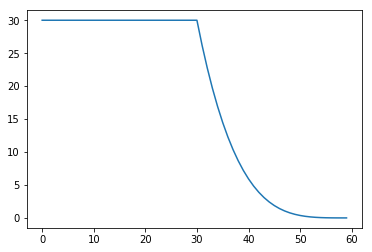

In [374]:
a = np.ones(60)
for i in xrange(a.shape[0]):
    x = np.sum(a[i:])
    if (x >= 30):
        a[i] = 30
    else:
        a[i] = 30*((-x/30)**4)
#         a[i] = 60*(1/(1+np.exp((30-x)/5.0))

plt.plot(a)
plt.show()

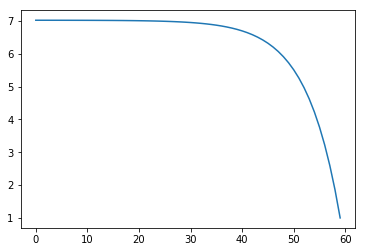

In [394]:
a = np.ones(60)
gamma = 0.8576
for i in xrange(a.shape[0]-2, -1, -1):
    a[i] = a[i] + gamma*a[i+1]

plt.plot(a)
plt.show()